In [5]:
import torch
from transformers import ViTModel, ViTFeatureExtractor

device = 'mps' if torch.backends.mps.is_available() else 'cpu'

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device)
model.eval()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

In [ ]:
from PIL import Image
import requests

url = "https://img.buzzfeed.com/buzzfeed-static/static/2023-03/10/12/asset/d1bc84dacf70/sub-buzz-546-1678451040-1.jpg?downsize=900:*&output-format=auto&output-quality=auto"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
inputs = feature_extractor(images=image, return_tensors="pt").to(device)

In [20]:
inputs = {k: v.to(device) for k, v in inputs.items()}

In [22]:
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)
attentions = outputs.attentions 

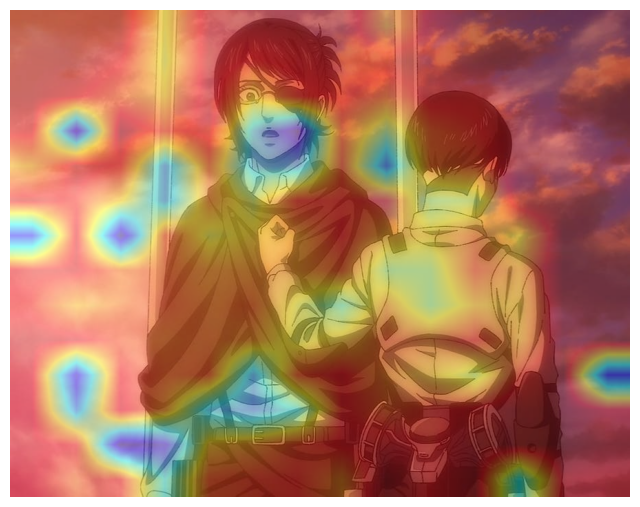

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def visualize_attention_on_image(image, attention_map):
    attention_map = cv2.resize(attention_map, (image.width, image.height))
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())
    
    img_np = np.array(image)
    heatmap = cv2.applyColorMap((attention_map*255).astype(np.uint8), cv2.COLORMAP_JET)
    blended = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)
    
    plt.figure(figsize=(8,8))
    plt.imshow(blended)
    plt.axis('off')
    plt.show()

layer_to_visualize = 5
head_to_visualize = 0
cls_attn = attentions[layer_to_visualize][0, head_to_visualize, 0, 1:].reshape(14,14).cpu().numpy()
visualize_attention_on_image(image, cls_attn)


In [ ]:
from sklearn.cluster import KMeans

def extract_all_heads_attn(attentions, layer):
    num_heads = attentions[layer].shape[1]
    head_attns = []
    for h in range(num_heads):
        attn_map = attentions[layer][0, h, 0, 1:].cpu().numpy().reshape(-1)
        head_attns.append(attn_map)
    return np.stack(head_attns) 

head_attns = extract_all_heads_attn(attentions, layer_to_visualize)
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(head_attns)
clusters

array([2, 2, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1], dtype=int32)

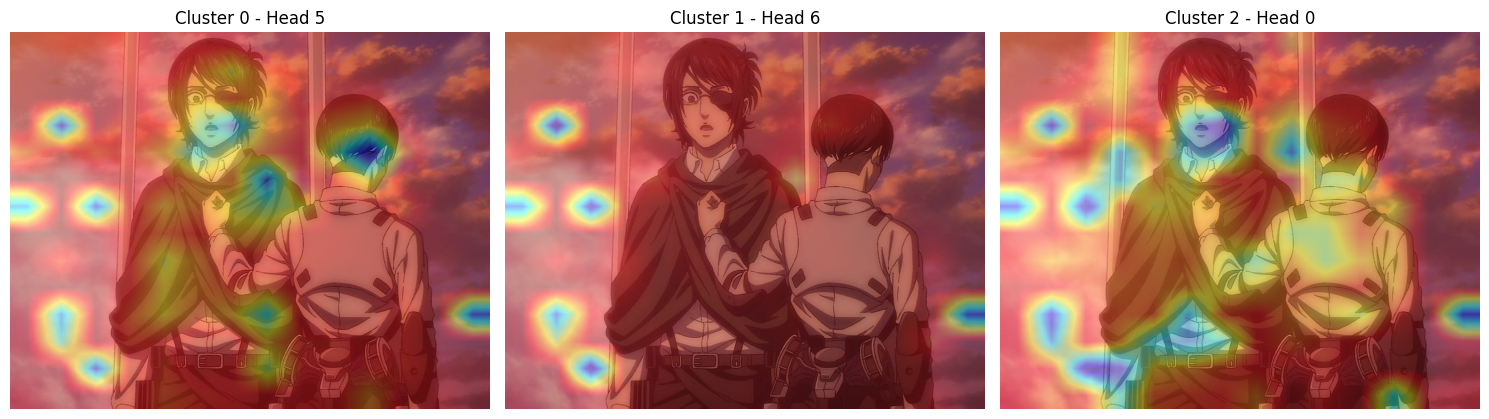

In [29]:
import matplotlib.pyplot as plt


num_clusters = 3
representative_heads = []

for c in range(num_clusters):
    heads_in_cluster = np.where(clusters == c)[0]  
    if len(heads_in_cluster) == 0:
        continue
    representative_head = heads_in_cluster[0]
    representative_heads.append(representative_head)

fig, axes = plt.subplots(1, num_clusters, figsize=(5 * num_clusters, 5))

for i, h_idx in enumerate(representative_heads):
    attn_map = attentions[layer_to_visualize][0, h_idx, 0, 1:].cpu().numpy().reshape(14,14)
    
    resized_map = cv2.resize(attn_map, (image.width, image.height))
    norm_map = (resized_map - resized_map.min()) / (resized_map.max() - resized_map.min())
    img_np = np.array(image)
    heatmap = cv2.applyColorMap((norm_map*255).astype(np.uint8), cv2.COLORMAP_JET)
    blended = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    axes[i].imshow(blended)
    axes[i].axis('off')
    axes[i].set_title(f"Cluster {i} - Head {h_idx}")

plt.tight_layout()
plt.show()


In [27]:
def mask_top_patches(image, attention_map, top_k=5):
    flat_attn = attention_map.flatten()
    top_indices = np.argsort(flat_attn)[-top_k:]

    patch_size = 16
    h_patches = w_patches = 14
    img_array = np.array(image)

    for idx in top_indices:
        row, col = divmod(idx, w_patches)
        y_start, x_start = row*patch_size, col*patch_size
        img_array[y_start:y_start+patch_size, x_start:x_start+patch_size] = 128  # Gray patch

    return Image.fromarray(img_array)

masked_image = mask_top_patches(image, cls_attn, top_k=5)
masked_inputs = feature_extractor(images=masked_image, return_tensors="pt").to(device)
with torch.no_grad():
    masked_outputs = model(**masked_inputs, output_attentions=True)

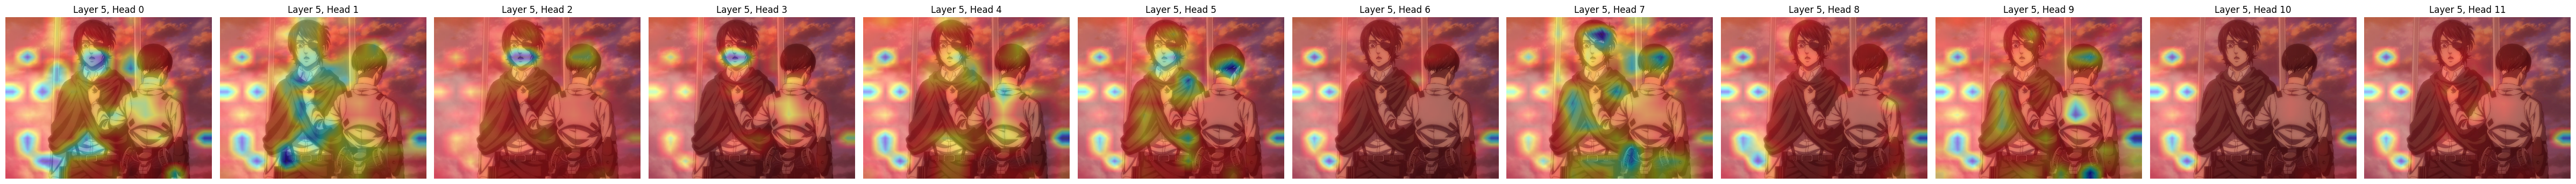

In [30]:
# Assuming:
# - model has been loaded
# - image is a PIL image
# - inputs = feature_extractor(images=image, return_tensors="pt").to(device)
# - outputs = model(**inputs, output_attentions=True)
# - attentions = outputs.attentions

layer_to_visualize = 5  # Choose a layer index
num_heads = attentions[layer_to_visualize].shape[1]

# Convert the image to a NumPy array for visualization
img_np = np.array(image)
img_height, img_width = img_np.shape[:2]

# Assume a ViT with 14x14 patches (224x224 image with patch_size=16, for ViT-B/16)
patch_grid = 14

fig, axes = plt.subplots(1, num_heads, figsize=(4*num_heads, 4))
if num_heads == 1:
    axes = [axes]  # Ensure axes is iterable even if there's only one head

for h in range(num_heads):
    # Extract CLS attention for head h
    cls_attention = attentions[layer_to_visualize][0, h, 0, 1:].detach().cpu().numpy()
    attn_map = cls_attention.reshape(patch_grid, patch_grid)

    # Resize attention map to image size
    attn_resized = cv2.resize(attn_map, (img_width, img_height))

    # Normalize the attention map [0,1] for visualization
    attn_norm = (attn_resized - attn_resized.min()) / (attn_resized.max() - attn_resized.min())

    # Create a heatmap
    heatmap = cv2.applyColorMap((attn_norm*255).astype(np.uint8), cv2.COLORMAP_JET)

    # Blend the heatmap with the original image
    blended = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    axes[h].imshow(blended)
    axes[h].axis('off')
    axes[h].set_title(f"Layer {layer_to_visualize}, Head {h}")

plt.tight_layout()
plt.show()